In [21]:
import pandas as pd
import os
import glob
import chardet
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
# List of state abbreviations
state_abbreviations = ['AZ', 'CA', 'CO', 'ID', 'MT', 'NM', 'NV', 'OR', 'UT', 'WA', 'WY']

# Path to the folder containing CSV files for each state
folder_path = '/Users/natebender/Documents/ArcGIS/Projects/Western_protected_lands/BEA_economics_CAEMP25N_raw/'
ref_codes_df_path = os.path.join(folder_path, 'county_fips_master.csv')
ref_codes_df = pd.read_csv(ref_codes_df_path, encoding='latin-1')  # Use 'latin-1' encoding

In [3]:
ref_codes_df.head()

,fips,county_name,state_abbr,state_name,long_name,sumlev,region,division,state,county,crosswalk,region_name,division_name
0,1001,Autauga County,AL,Alabama,Autauga County AL,50.0,3.0,6.0,1.0,1.0,3-6-1-1,South,East South Central
1,1003,Baldwin County,AL,Alabama,Baldwin County AL,50.0,3.0,6.0,1.0,3.0,3-6-1-3,South,East South Central
2,1005,Barbour County,AL,Alabama,Barbour County AL,50.0,3.0,6.0,1.0,5.0,3-6-1-5,South,East South Central
3,1007,Bibb County,AL,Alabama,Bibb County AL,50.0,3.0,6.0,1.0,7.0,3-6-1-7,South,East South Central
4,1009,Blount County,AL,Alabama,Blount County AL,50.0,3.0,6.0,1.0,9.0,3-6-1-9,South,East South Central


In [4]:
# Iterate over each state abbreviation
    
for state_abbr in state_abbreviations:
    # Construct the full file path
    file_pattern = f'CAEMP25N_{state_abbr}_2001_2021.csv'
    file_path = os.path.join(folder_path, file_pattern)

    # Use chardet to detect & deal with the encoding bc NM is a different encoding for some WTF reason
    with open(file_path, 'rb') as file:
        rawdata = file.read()
        result = chardet.detect(rawdata)
        encoding = result['encoding']
                
    # Read the CSV file with the detected encoding
    df = pd.read_csv(file_path, encoding=encoding)    
    
    if len(file_path) == 0:
        print(f"No files found for state {state_abbr}")
        continue
    
    col_list = ['GeoFIPS','GeoName','LineCode','Description','2001','2002','2003','2004','2005','2006','2007','2008'
                ,'2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']

    subset = df[col_list].copy()    
    
    # Create a new column list with renamed year columns
    new_col_list = ['GeoFIPS', 'GeoName', 'LineCode', 'Description'] + [f'yr_{year}' for year in range(2001, 2022)]
    
    subset.columns = new_col_list
    
    # subset to just the total number of jobs per county
    subset_two = subset[subset['LineCode'] == 10].copy()
    
    # filter out the rows with state-level data. These just list the state name; the rows w/ counties contain a comma.
    subset_two = subset_two[subset_two['GeoName'].str.contains(',', na=False)]

    # Clean the 'GeoFIPS' column to remove non-numeric characters
    subset_two['GeoFIPS'] = subset_two['GeoFIPS'].str.replace(r'[^0-9]', '', regex=True)
 
    # Convert the 'GeoFIPS' column to numeric values
    subset_two['GeoFIPS'] = pd.to_numeric(subset_two['GeoFIPS'], errors='coerce')
    
    # rename year to string rather than number; ArcGIS struggles with numbers as col names
    subset_two = subset_two.rename(columns={'GeoFIPS': 'geofips'})

    # drop the geonames, they're unnecessary now
    subset_two = subset_two.drop('GeoName', axis=1)
    
    # rename cols to lowercase
    subset_two = subset_two.rename(columns={'LineCode': 'linecode'})
    subset_two = subset_two.rename(columns={'Description': 'description'})

    # Create the output file path using the state abbreviation
    output_file_path = f'/Users/natebender/Documents/ArcGIS/Projects/Western_protected_lands/BEA_economics_CAEMP25N_clean/{state_abbr}_2001_2021.csv'

    # Save the cleaned DataFrame to the output file
    subset_two.to_csv(output_file_path, index=False)


In [5]:
# Combine state files into one

# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Path to the folder containing CSV files for each state
folder_path = '/Users/natebender/Documents/ArcGIS/Projects/Western_protected_lands/BEA_economics_CAEMP25N_clean/'

# Iterate over each state abbreviation
for state_abbr in state_abbreviations:
    # Construct the file path for the cleaned CSV
    file_path = os.path.join(folder_path, f'{state_abbr}_2001_2021.csv')
    
    # Read the cleaned CSV for the state
    state_df = pd.read_csv(file_path)
    
    # Append the state's data to the combined DataFrame
    combined_df = combined_df.append(state_df, ignore_index=True)

    # and shorten the description string for easier processing later on
    combined_df['description'] = 'total employment'



In [6]:
# Merge based on common columns (region, division, state, county)
ref_codes_df = ref_codes_df.rename(columns={'fips': 'geofips'})

final_df = combined_df.merge(ref_codes_df[['region', 'division', 'state', 'county', 
                                           'state_name', 'county_name','geofips']], 
                                  on=['geofips'], how='left')

final_df = final_df.rename(columns={'state_name': 'stname'})
final_df = final_df.rename(columns={'county_name': 'ctyname'})

In [7]:
# Broomfield County, CO is our only NA row in this employment data. 
# This is because the county was formed in Nov 2001.
# The city of Broomfield lies within four existing CO counties: Adams, Jefferson, Boulder, and Weld.
# For now, I create a simple linear regression working backwards from its 2002-2021 job numbers to create
# an estimate of its 2001 jobs.

counties_to_check = ['Boulder County', 'Weld County', 'Adams County', 'Jefferson County', 'Broomfield County']
mask = (final_df['stname'] == 'Colorado') & (final_df['ctyname'].isin(counties_to_check))
final_df.loc[mask]

,geofips,linecode,description,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006,yr_2007,...,yr_2018,yr_2019,yr_2020,yr_2021,region,division,state,county,stname,ctyname
73,8001,10.0,total employment,182690,182330,180259,183234,190371,197464,203454,...,286944,300255,300311,309663,4.0,8.0,8.0,1.0,Colorado,Adams County
79,8013,10.0,total employment,243644,215538,210519,214515,218044,221750,228962,...,274079,275800,269173,277978,4.0,8.0,8.0,13.0,Colorado,Boulder County
80,8014,10.0,total employment,(NA),32328,33202,35548,37650,39100,40938,...,53035,53888,52743,53913,4.0,8.0,8.0,14.0,Colorado,Broomfield County
103,8059,10.0,total employment,293794,291519,290710,292822,297456,299719,309079,...,356958,357999,349736,356666,4.0,8.0,8.0,59.0,Colorado,Jefferson County
135,8123,10.0,total employment,103132,104924,108331,112357,116668,121484,126301,...,162377,166365,163078,164157,4.0,8.0,8.0,123.0,Colorado,Weld County


In [11]:
# Filter the DataFrame for the relevant rows
broomfield_data = final_df[(final_df['geofips'] == 8014) & (final_df['linecode'] == 10.0)]

# Extract the years from 2002 to 2021
years = np.arange(2002, 2022).reshape(-1, 1)

# Extract the employment figures for those years
employment_data = broomfield_data[['yr_' + str(year) for year in years.ravel()]]


In [51]:
# Create a linear regression model
model = LinearRegression()
model.fit(years, employment_data.values.reshape(-1, 1))

# Use the trained model to predict the employment for 2001
#predicted_employment_2001 = model.predict(np.array([[2001]]))

# Use the trained model to predict the employment for 2001
predicted_employment_2001 = model.predict(np.array([[2001]])).item()

# Round up the predicted value to the nearest whole number
int_predicted_employment_2001 = int(predicted_employment_2001)

# Update the DataFrame with the predicted value
final_df.loc[(final_df['geofips'] == 8014) & (final_df['linecode'] == 10.0), 'yr_2001'] = int_predicted_employment_2001

print(f"Predicted employment for 2001 in Broomfield County: {int_predicted_employment_2001}")

Predicted employment for 2001 in Broomfield County: 31954


In [47]:
final_df.loc[(final_df['geofips'] == 8014)]

,geofips,linecode,description,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006,yr_2007,...,yr_2018,yr_2019,yr_2020,yr_2021,region,division,state,county,stname,ctyname
80,8014,10.0,total employment,31954,32328,33202,35548,37650,39100,40938,...,53035,53888,52743,53913,4.0,8.0,8.0,14.0,Colorado,Broomfield County


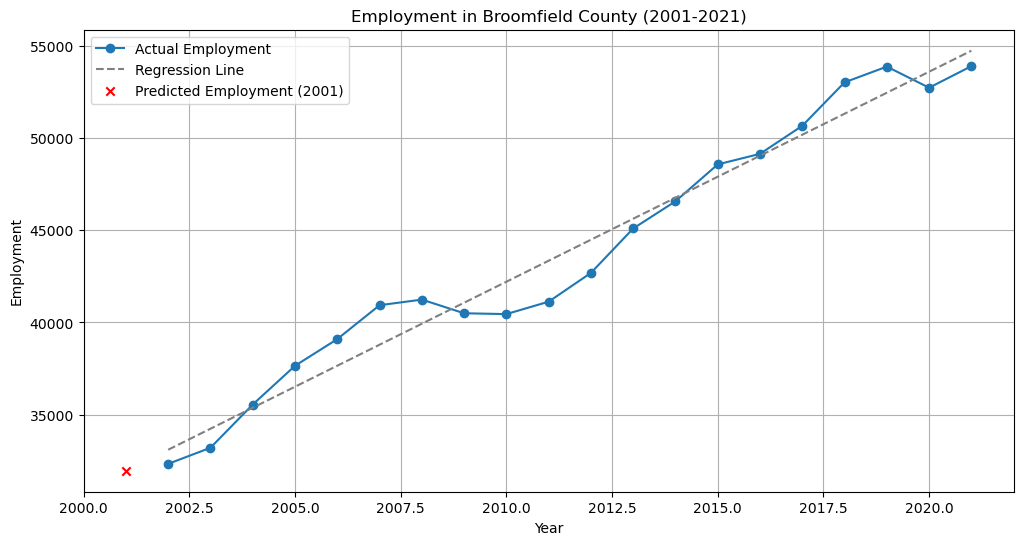

In [52]:
# Prepare the data for plotting
actual_employment = employment_data.values[0]

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(years, actual_employment, label='Actual Employment', marker='o')
plt.scatter(2001, predicted_employment_2001, color='red', marker='x', label='Predicted Employment (2001)')
plt.plot(years, model.predict(years.reshape(-1, 1)), linestyle='--', color='gray', label="Regression Line")
plt.xlabel('Year')
plt.ylabel('Employment')
plt.title('Employment in Broomfield County (2001-2021)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [53]:
counties_to_check = ['Boulder County', 'Weld County', 'Adams County', 'Jefferson County', 'Broomfield County']
mask = (final_df['stname'] == 'Colorado') & (final_df['ctyname'].isin(counties_to_check))
final_df.loc[mask]

,geofips,linecode,description,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006,yr_2007,...,yr_2018,yr_2019,yr_2020,yr_2021,region,division,state,county,stname,ctyname
73,8001,10.0,total employment,182690,182330,180259,183234,190371,197464,203454,...,286944,300255,300311,309663,4.0,8.0,8.0,1.0,Colorado,Adams County
79,8013,10.0,total employment,243644,215538,210519,214515,218044,221750,228962,...,274079,275800,269173,277978,4.0,8.0,8.0,13.0,Colorado,Boulder County
80,8014,10.0,total employment,31954,32328,33202,35548,37650,39100,40938,...,53035,53888,52743,53913,4.0,8.0,8.0,14.0,Colorado,Broomfield County
103,8059,10.0,total employment,293794,291519,290710,292822,297456,299719,309079,...,356958,357999,349736,356666,4.0,8.0,8.0,59.0,Colorado,Jefferson County
135,8123,10.0,total employment,103132,104924,108331,112357,116668,121484,126301,...,162377,166365,163078,164157,4.0,8.0,8.0,123.0,Colorado,Weld County


In [54]:
# Create the output file path for the combined data
output_file_path = '/Users/natebender/Documents/ArcGIS/Projects/Western_protected_lands/BEA_economics_CAEMP25N_clean/BEA_combined_2001_2021.csv'

# Save the combined data to the output CSV file
final_df.to_csv(output_file_path, index=False)